In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pyuvdata import UVBeam

In [2]:
beam = np.load('/Users/ruby/Astro/LWA_beams/beamJones_28.68.npz')
print(beam.files[0])
print(np.shape(beam['J']))
beam = beam['J']

J
(2, 2, 4096, 4096)


In [3]:
# Get rid of pixels with nans
bad_pixels = np.where(np.isnan(np.sum(np.abs(beam), axis=(0,1))))
for pix_ind in range(len(bad_pixels[0])):
    beam[:, :, bad_pixels[0][pix_ind], bad_pixels[1][pix_ind]] = np.nan + 1j*np.nan

In [4]:
use_cmap = matplotlib.cm.get_cmap('Spectral')
use_cmap.set_bad(color='whitesmoke')
plt.rcParams.update({'mathtext.default':  'regular'})

<ipython-input-4-682272893560>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Spectral"))
  use_cmap.set_bad(color='whitesmoke')


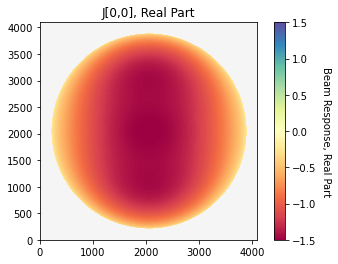

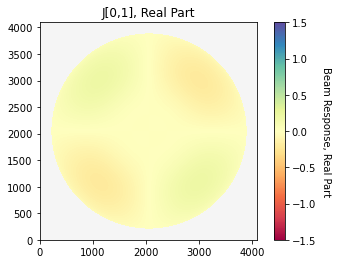

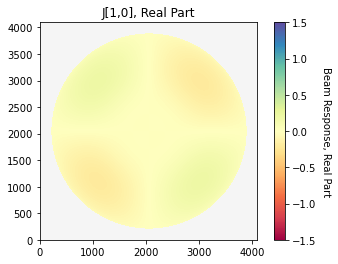

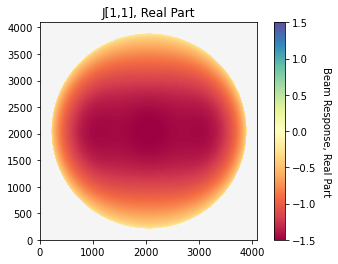

In [5]:
for ind1 in range(2):
    for ind2 in range(2):
        fig, ax = plt.subplots()
        plt.imshow(
            np.real(beam[ind1,ind2,:,:]), origin='lower',
            interpolation='none',
            vmin=-1.5, vmax=1.5,
            cmap=use_cmap
        )
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(
            'Beam Response, Real Part', rotation=270, labelpad=15
        )
        plt.title(f'J[{ind1},{ind2}], Real Part')

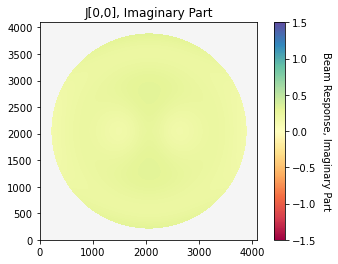

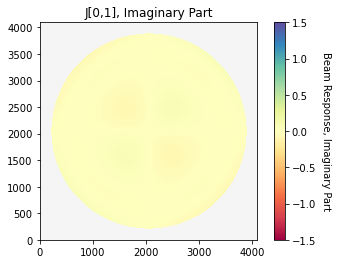

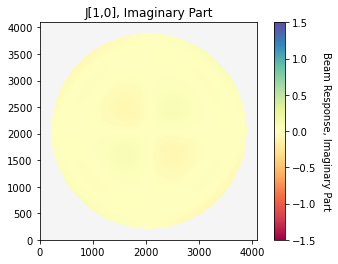

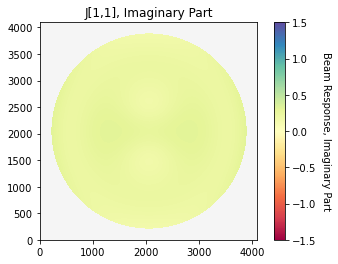

In [6]:
for ind1 in range(2):
    for ind2 in range(2):

        fig, ax = plt.subplots()
        plt.imshow(
            np.imag(beam[ind1,ind2,:,:]), origin='lower',
            interpolation='none',
            vmin=-1.5, vmax=1.5,
            cmap=use_cmap
        )
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(
            'Beam Response, Imaginary Part', rotation=270, labelpad=15
        )
        plt.title(f'J[{ind1},{ind2}], Imaginary Part')

In [7]:
# Read beam simulation generated by David Woody, from Marin Anderson
with open('/Users/ruby/Astro/LWA_beams/DW_beamquadranttable20151110.txt', 'r') as f:
    lines = f.readlines()
f.close()

In [8]:
header = lines[6]
npoints = len(lines)-7

za_deg = np.zeros(npoints, dtype=float)
az_deg = np.zeros(npoints, dtype=float)
freq_mhz = np.zeros(npoints, dtype=float)
jones_theta = np.zeros(npoints, dtype=complex)
jones_phi = np.zeros(npoints, dtype=complex)

In [9]:
print(header)

theta[deg]	phi[deg]	freq[MHz]	co[real]	co[imag]	cx[real]	cx[imag]	theta[real]	theta[imag]	phi[real]	phi[imag]



In [10]:
for point in range(npoints):
    line_data = [float(value) for value in lines[point+7].split()]
    za_deg[point] = line_data[0]
    az_deg[point] = line_data[1]
    freq_mhz[point] = line_data[2]
    jones_theta[point] = line_data[7] + 1j*line_data[8]
    jones_phi[point] = line_data[9] + 1j*line_data[10]

In [11]:
za_axis = np.arange(0., 90.+5., 5.)
az_axis = np.arange(0., 360., 5.)
freq_axis = np.arange(20., 80.+10., 10.)
jones = np.full((2, 2, len(freq_axis), len(za_axis), len(az_axis)), np.nan+1j*np.nan, dtype=complex)

# Flip the Jones matrix in particular quadrants
multiply_factors = np.ones((2, 2, 4), dtype=float)  # Shape (nfeeds, npols, nquadrants)
multiply_factors[0, 0, 0:2] = -1.
multiply_factors[0, 1, 1:3] = -1.
multiply_factors[1, 0, 0] = -1
multiply_factors[1, 0, 3] = -1
multiply_factors[1, 1, 0:2] = -1

for point in range(npoints):
    za_ind = np.where(za_axis == za_deg[point])
    freq_ind = np.where(freq_axis == freq_mhz[point])
    for pol in [0, 1]:
        use_az = az_deg[point]
        if pol == 0:
            use_az = 90.-use_az  # Q pol is rotated 90 degrees

        az_ind_quad_1 = np.where(az_axis == use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_1] = multiply_factors[0, pol, 0]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_1] = multiply_factors[1, pol, 0]*jones_phi[point]

        az_ind_quad_2 = np.where(az_axis == 180. - use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_2] = multiply_factors[0, pol, 1]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_2] = multiply_factors[1, pol, 1]*jones_phi[point]
        
        az_ind_quad_3 = np.where(az_axis == 180. + use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_3] = multiply_factors[0, pol, 2]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_3] = multiply_factors[1, pol, 2]*jones_phi[point]
        az_ind_quad_4 = np.where(az_axis == 360. - use_az)
        jones[0, pol, freq_ind, za_ind, az_ind_quad_4] = multiply_factors[0, pol, 3]*jones_theta[point]
        jones[1, pol, freq_ind, za_ind, az_ind_quad_4] = multiply_factors[1, pol, 3]*jones_phi[point]

jones = np.transpose(jones, axes=(1,0,2,3,4))
jones = np.flip(jones, axis=0)

In [12]:
a = np.array([1,2,3])
print(a[-1:1])

[]


In [13]:
plot_freq = 50.
plot_freq_ind = np.where(freq_axis == plot_freq)[0][0]

In [14]:
print(plot_freq_ind)

3


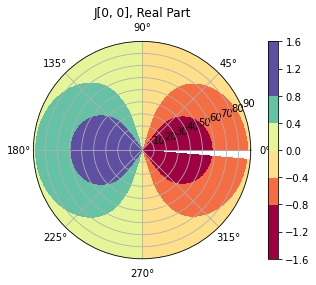

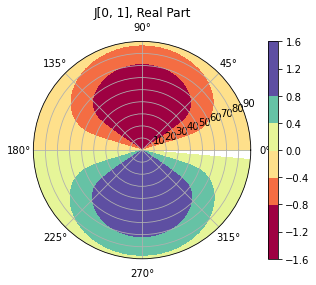

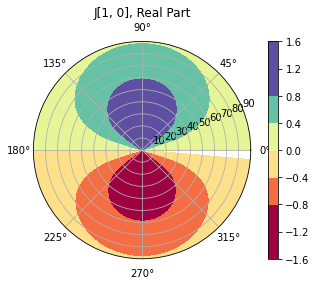

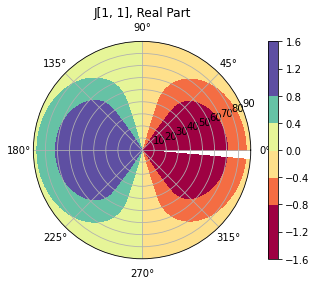

In [15]:
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)
for pol1 in [0, 1]:
    for pol2 in [0, 1]:
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        contourplot = ax.contourf(np.radians(theta_plot), r_plot, np.real(jones[pol1, pol2, plot_freq_ind, :, :]).T, vmin=-1, vmax=1, cmap=use_cmap)
        contourplot.set_clim(vmin=-1, vmax=1)
        cbar = fig.colorbar(contourplot)
        plt.title(f'J[{pol1}, {pol2}], Real Part')
        plt.show()

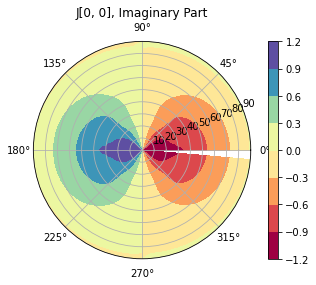

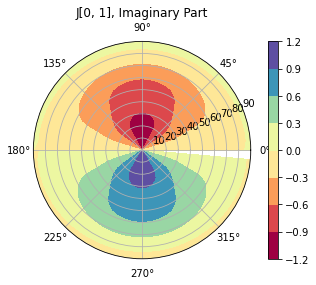

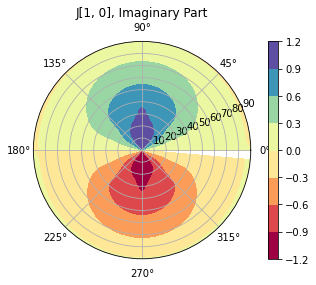

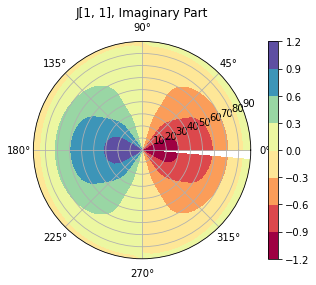

In [16]:
r_plot, theta_plot = np.meshgrid(za_axis, az_axis)
for pol1 in [0, 1]:
    for pol2 in [0, 1]:
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        contourplot = ax.contourf(np.radians(theta_plot), r_plot, np.imag(jones[pol1, pol2, plot_freq_ind, :, :]).T, vmin=-1, vmax=1, cmap=use_cmap)
        contourplot.set_clim(vmin=-1, vmax=1)
        cbar = fig.colorbar(contourplot)
        plt.title(f'J[{pol1}, {pol2}], Imaginary Part')
        plt.show()

In [17]:
beam_obj = UVBeam()
beam_obj.Naxes_vec = 2
beam_obj.Nfreqs = len(freq_axis)
beam_obj.Nspws = 1
beam_obj.antenna_type = 'simple'
beam_obj.bandpass_array = np.full((1, len(freq_axis)), 1.)
beam_obj.beam_type = 'efield'
beam_obj.data_array = jones[:, np.newaxis, :, :, :, :]
beam_obj.data_normalization = 'physical'
beam_obj.feed_name = ''
beam_obj.feed_version = ''
beam_obj.freq_array = freq_axis[np.newaxis, :]*1e6  # Convert from MHz to Hz
beam_obj.history = ''
beam_obj.model_name = ''
beam_obj.model_version = ''
beam_obj.pixel_coordinate_system = 'az_za'
beam_obj.spw_array = [0]
beam_obj.telescope_name = 'LWA'
beam_obj.Naxes1 = len(az_axis)
beam_obj.Naxes2 = len(za_axis)
beam_obj.Ncomponents_vec = 2
beam_obj.Nfeeds = 2
beam_obj.Npols = 2
beam_obj.axis1_array = np.radians(az_axis)
beam_obj.axis2_array = np.radians(za_axis)
beam_obj.basis_vector_array = np.repeat((np.repeat(
    (np.identity(2, dtype=float))[:, :, np.newaxis], len(za_axis), axis=2
))[:,:,:,np.newaxis], len(az_axis), axis=3)
beam_obj.feed_array = ['E', 'N']
beam_obj.x_orientation = 'east'
beam_obj.peak_normalize()
beam_obj.check()

True

In [18]:
beam_obj.write_beamfits('/Users/ruby/Astro/LWA_beams/LWAbeam_2015_new.fits')

In [19]:
print(freq_mhz)

[20. 20. 20. ... 80. 80. 80.]


In [20]:
import sys
sys.path.append('/Users/ruby/Astro/rlb_MWA/sky_imaging/')
import plot_fits

In [21]:
beam_xx = plot_fits.load_image('/Users/ruby/Astro/FHD_outputs/fhd_rlb_test_LWA_data_one_beam/output_data/2019-11-21T23:00:08_Beam_XX.fits')
beam_yy = plot_fits.load_image('/Users/ruby/Astro/FHD_outputs/fhd_rlb_test_LWA_data_one_beam/output_data/2019-11-21T23:00:08_Beam_YY.fits')
plot_fits.plot_fits_image(beam_xx)
plot_fits.plot_fits_image(beam_yy)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ruby/Astro/FHD_outputs/fhd_rlb_test_LWA_data_one_beam/output_data/2019-11-21T23:00:08_Beam_XX.fits'

In [ ]:
lwa_beam = UVBeam()
lwa_beam.read_beamfits('/Users/ruby/Astro/LWA_beams/LWAbeam_2015_new.fits')  # Try re-reading to see if it matches
lwa_beam.peak_normalize()
hera_beam = UVBeam()
hera_beam.read_beamfits('/Users/ruby/Astro/HERA-Beams/NicolasFagnoniBeams/NF_HERA_Vivaldi_efield_beam.fits')
hera_beam.peak_normalize()

In [ ]:
def plot_uvbeam(beam_obj, plot_freq_ind=3):
    az_axis_use = np.degrees(beam_obj.axis1_array)
    za_axis_use = np.degrees(beam_obj.axis2_array)
    r_plot, theta_plot = np.meshgrid(za_axis_use, az_axis_use)
    use_jones = np.squeeze(beam_obj.data_array, axis=1)  # Remove spw axis
    for plot_real in [True, False]:
        for pol1 in [0, 1]:
            for pol2 in [0, 1]:
                if plot_real:
                    plot_vals = np.real(use_jones[pol1, pol2, plot_freq_ind, :, :]).T
                else:
                    plot_vals = np.imag(use_jones[pol1, pol2, plot_freq_ind, :, :]).T
                fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
                contourplot = ax.contourf(np.radians(theta_plot), r_plot, plot_vals, vmin=-1, vmax=1, cmap=use_cmap)
                contourplot.set_clim(vmin=-1, vmax=1)
                cbar = fig.colorbar(contourplot)
                if plot_real:
                    title = f'J[{pol1}, {pol2}], Real Part'
                else:
                    title = f'J[{pol1}, {pol2}], Imaginary Part'
                plt.title(title)
                if plot_real:
                    savename = f'lwa_jones{pol1}{pol2}_freq{plot_freq_ind}_real'
                else:
                    savename = f'lwa_jones{pol1}{pol2}_freq{plot_freq_ind}_imag'
                plt.savefig(f'/Users/ruby/Astro/beam_debugging_plots_Oct2021/{savename}')
                plt.show()

In [ ]:
plot_uvbeam(lwa_beam, plot_freq_ind=6)

In [ ]:
hera_beam.feed_array

In [ ]:
lwa_beam.feed_array